# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from main import deterministic_training_notebook
from Environment import DecisionRule

In [3]:
feature_num = 3
action_num = 2
learning_rate_theta = 3e-5
decay_rate = 0  # 0.001
learning_rate_wv = 3e-3
learning_rate_wq = 3e-2
memory_size = 16
batch_size = 16
training_episodes = int(3e6)
beta1 = 0.9
beta2 = 0.9999
fixed_std = 0.2
# Algorithm: adam, momentum, regular
algorithm = 'regular'
# Bucket parameters
# prior_red_list = [3 / 4, 1 / 4]
prior_red_list = [0.6, 0.4]
pr_red_ball_red_bucket = 2 / 3
pr_red_ball_blue_bucket = 1 / 3
agent_num = 2

explorer_learning = False
decision_rule = DecisionRule.STOCHASTIC
preferred_colour_pr_list = [0.7, 0.3]
agent_list = []

system_accumulated_reward = deterministic_training_notebook(agent_list, feature_num, action_num, learning_rate_theta, learning_rate_wv, learning_rate_wq,
                                             memory_size, batch_size, training_episodes,
                                             decay_rate, beta1, beta2, algorithm, pr_red_ball_red_bucket,
                                             pr_red_ball_blue_bucket, prior_red_list, agent_num,
                                             explorer_learning, fixed_std, decision_rule, preferred_colour_pr_list)

  0%|          | 0/3000000 [00:00<?, ?it/s]

agent0
learning_rate_theta= 3e-05
learning_rate_wv= 0.003  learning_rate_wq= 0.03
memory_size= 16
Updating weights with regular algorithm.
agent1
learning_rate_theta= 3e-05
learning_rate_wv= 0.003  learning_rate_wq= 0.03
memory_size= 16
Updating weights with regular algorithm.


In [4]:
print(system_accumulated_reward/training_episodes)

0.540344


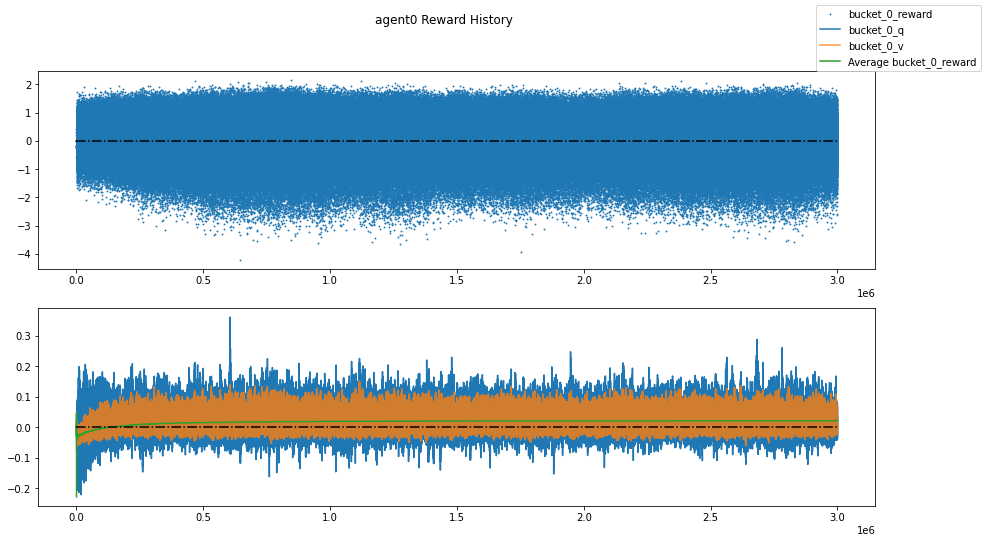

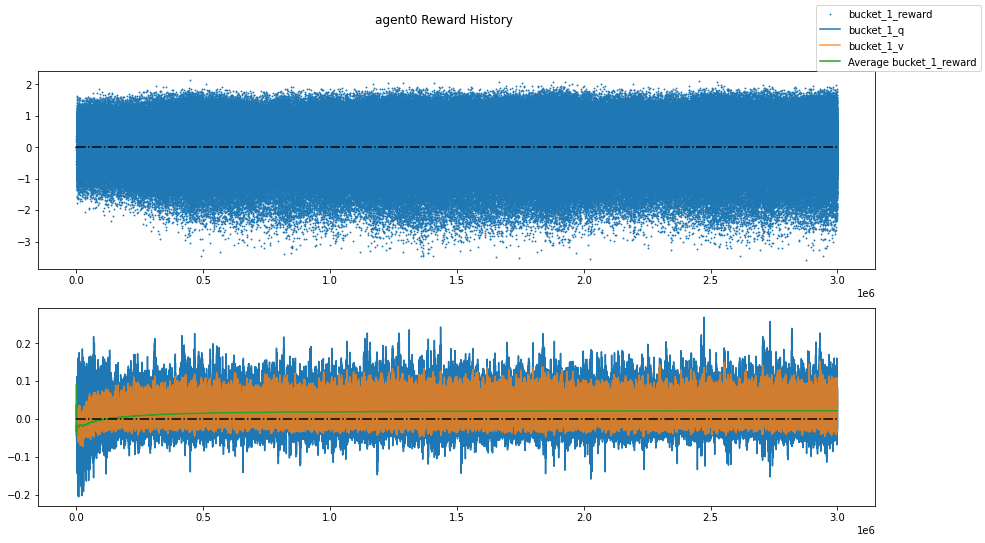

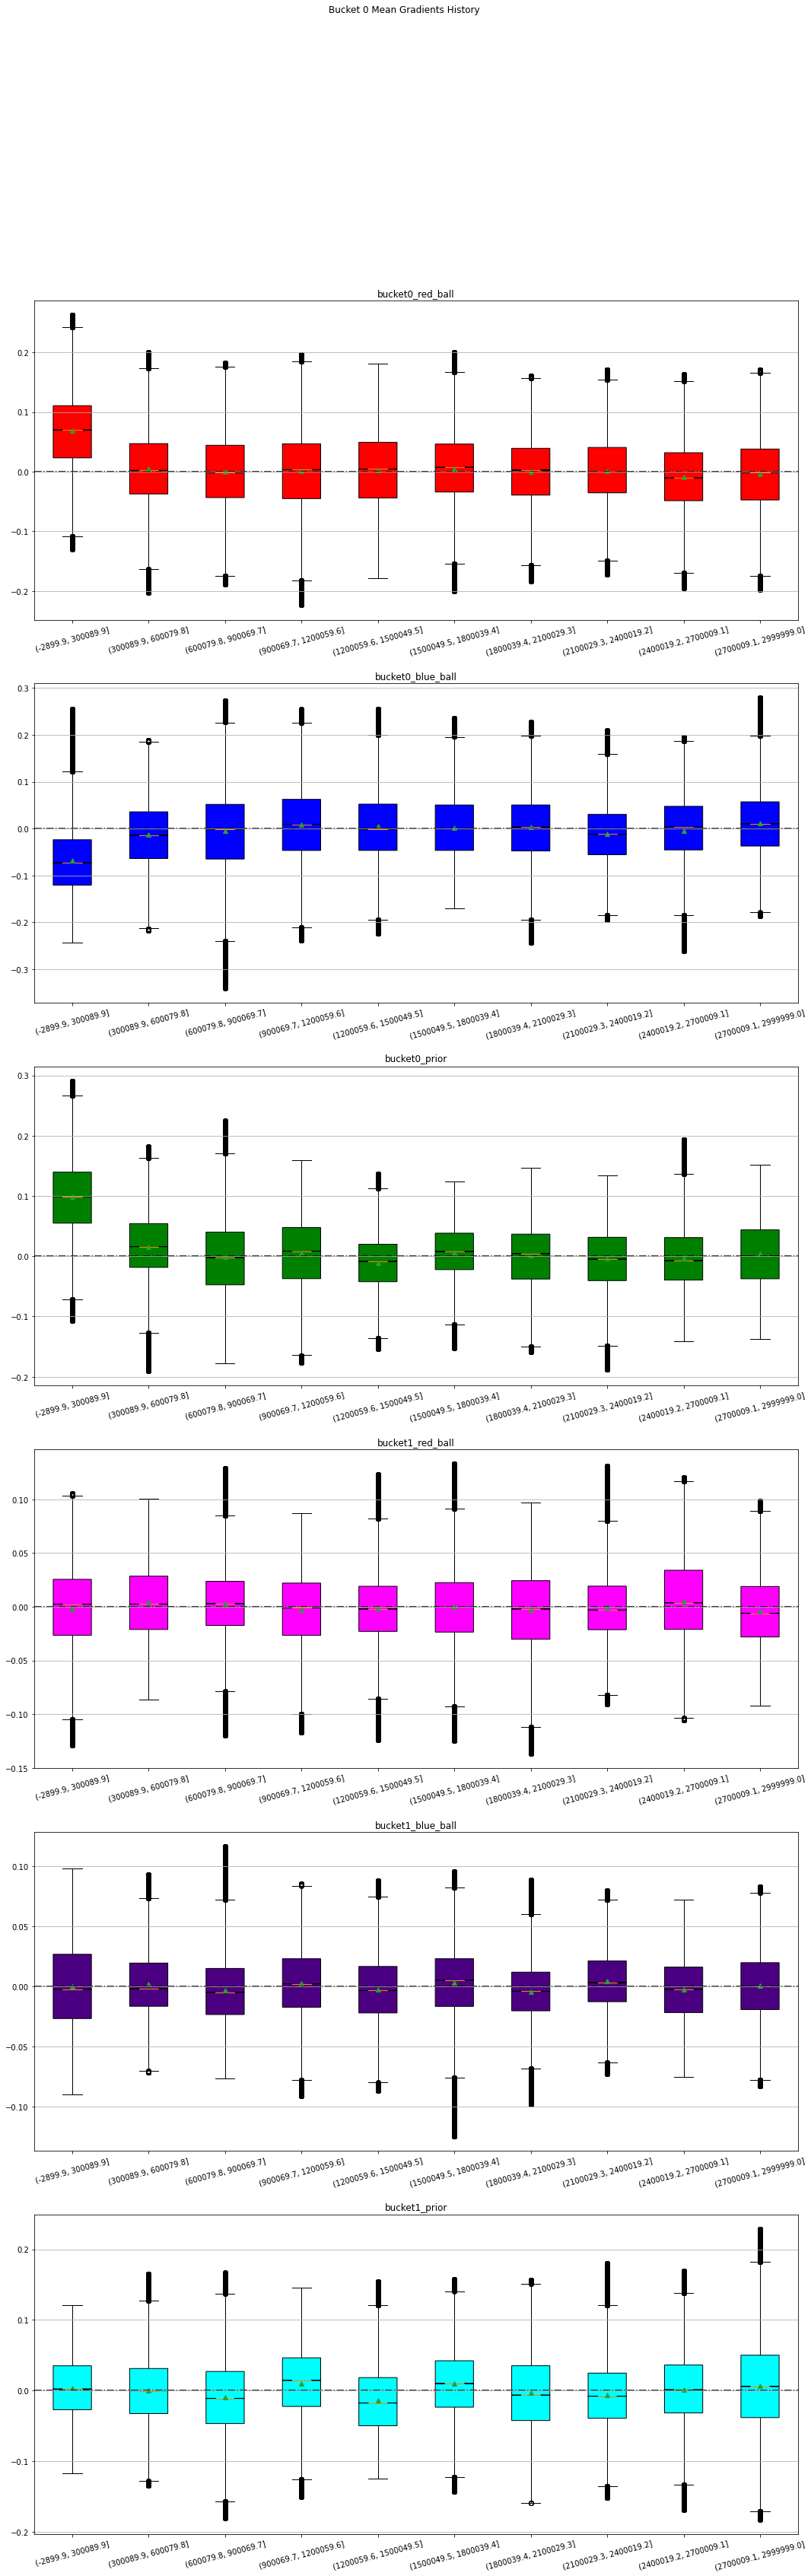

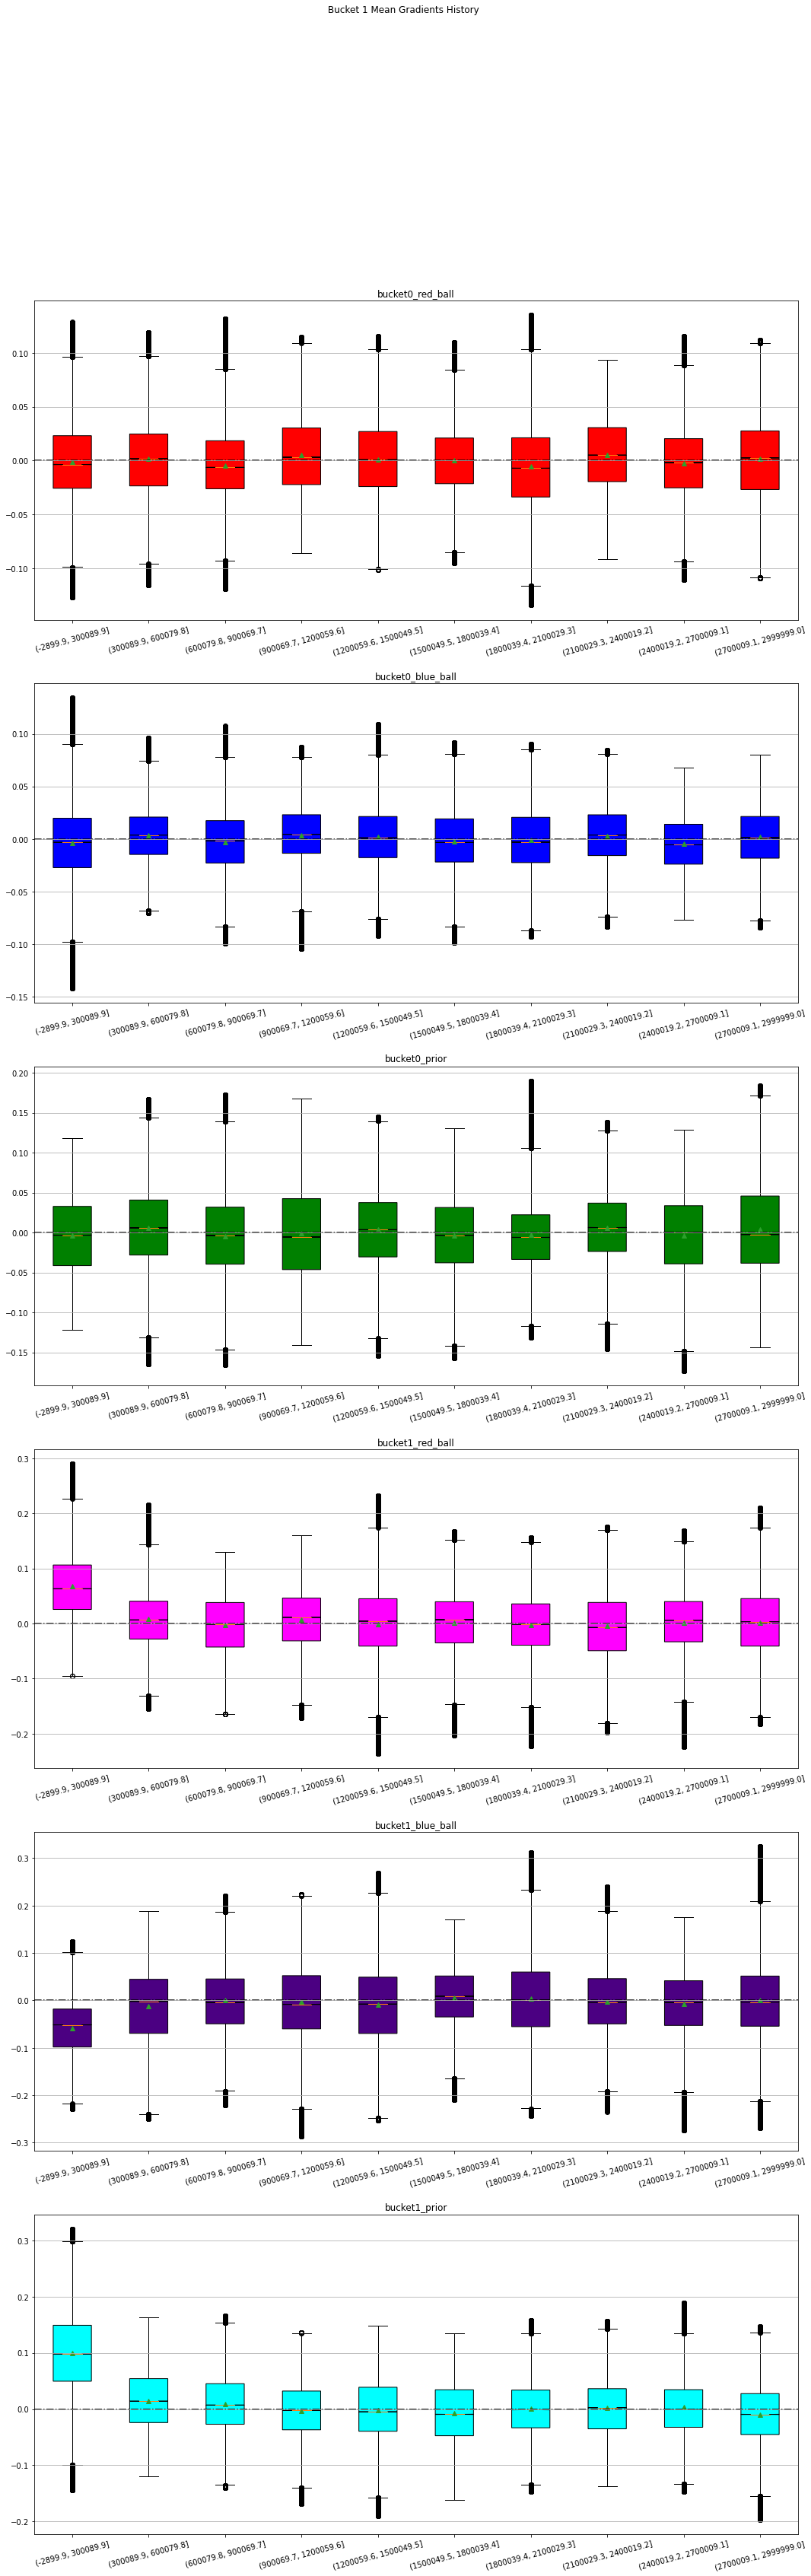

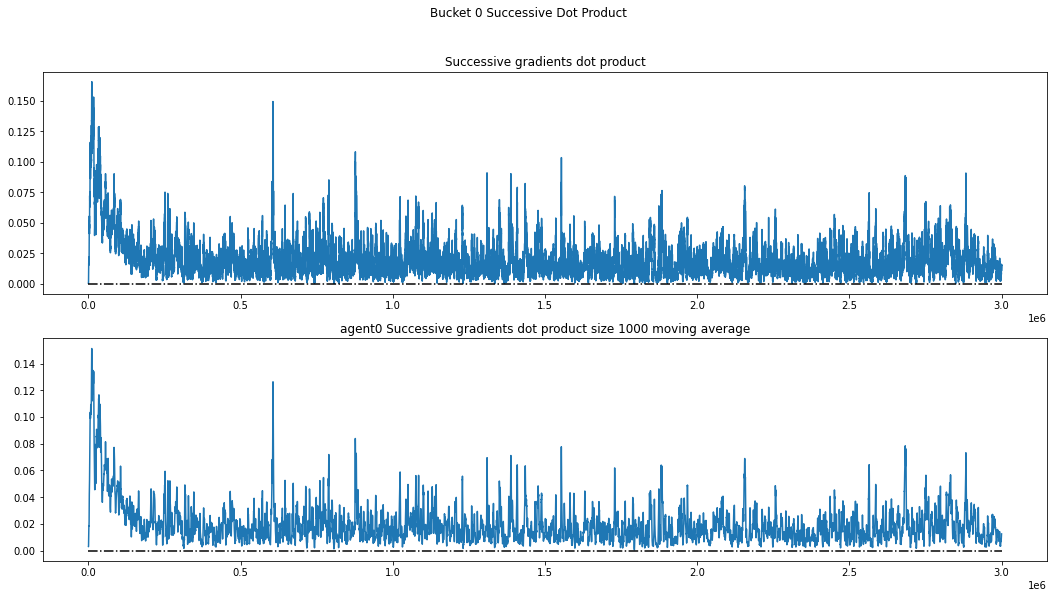

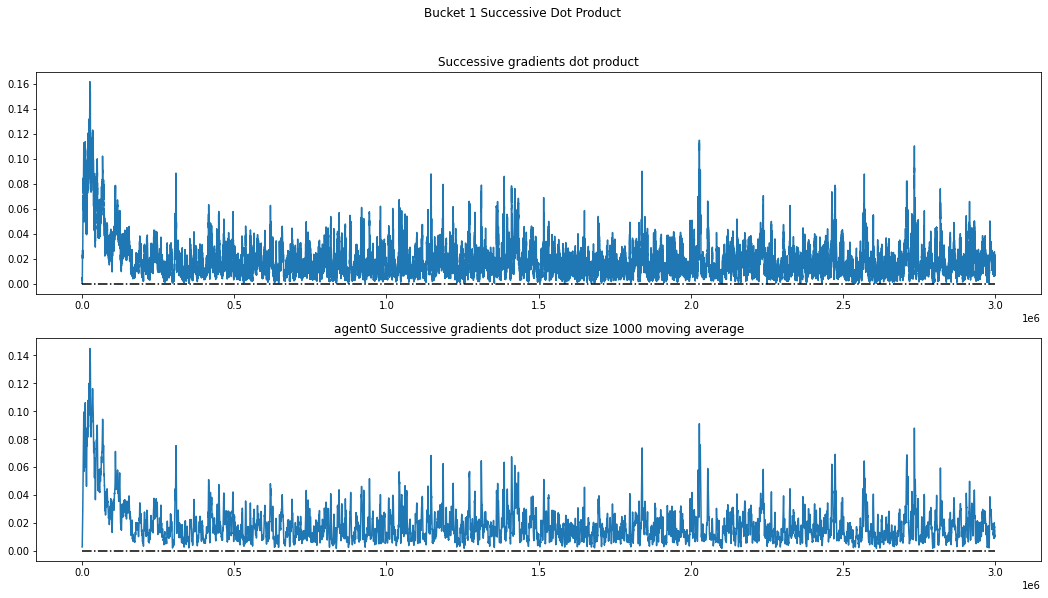

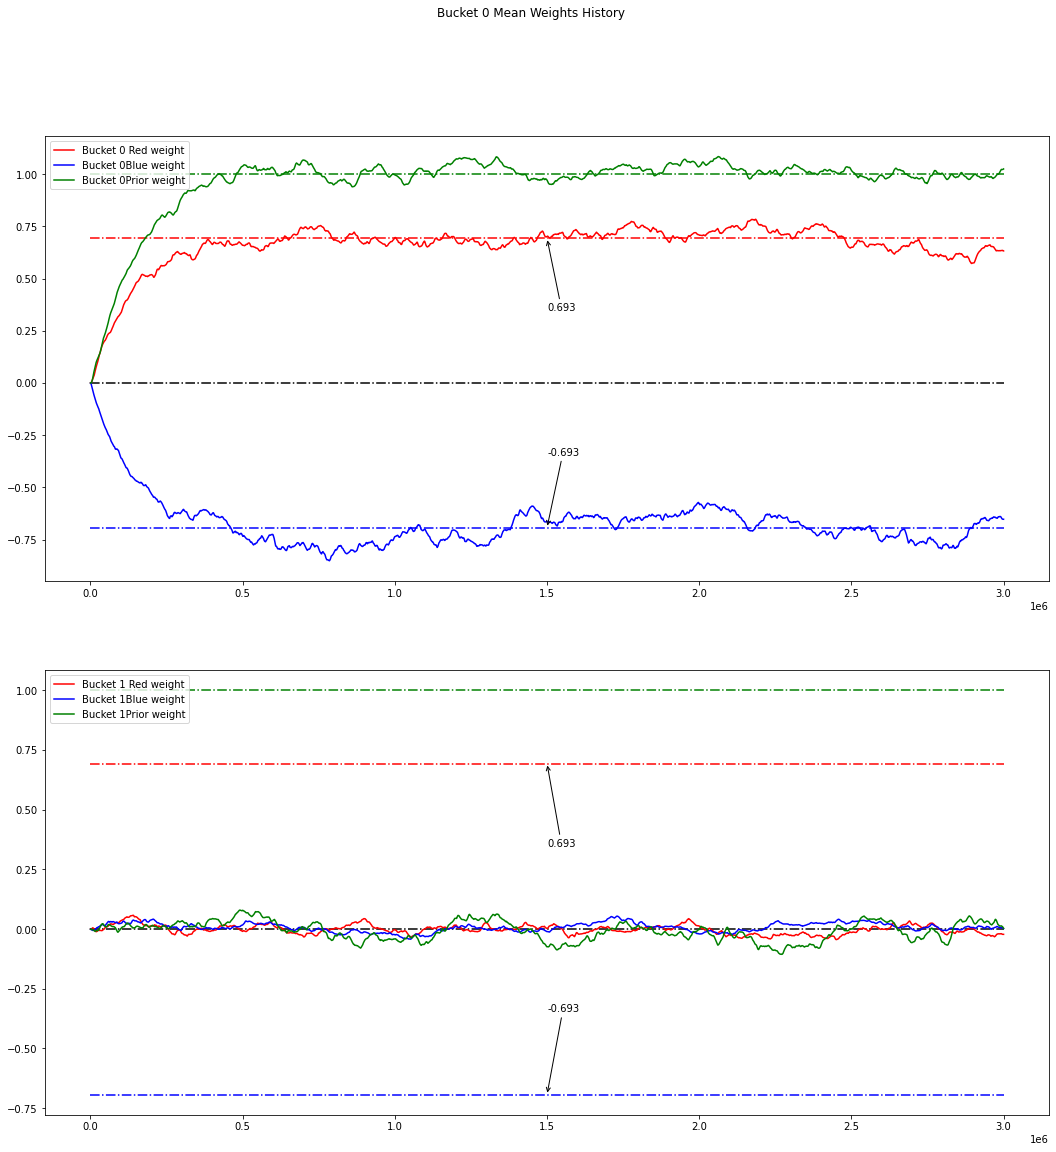

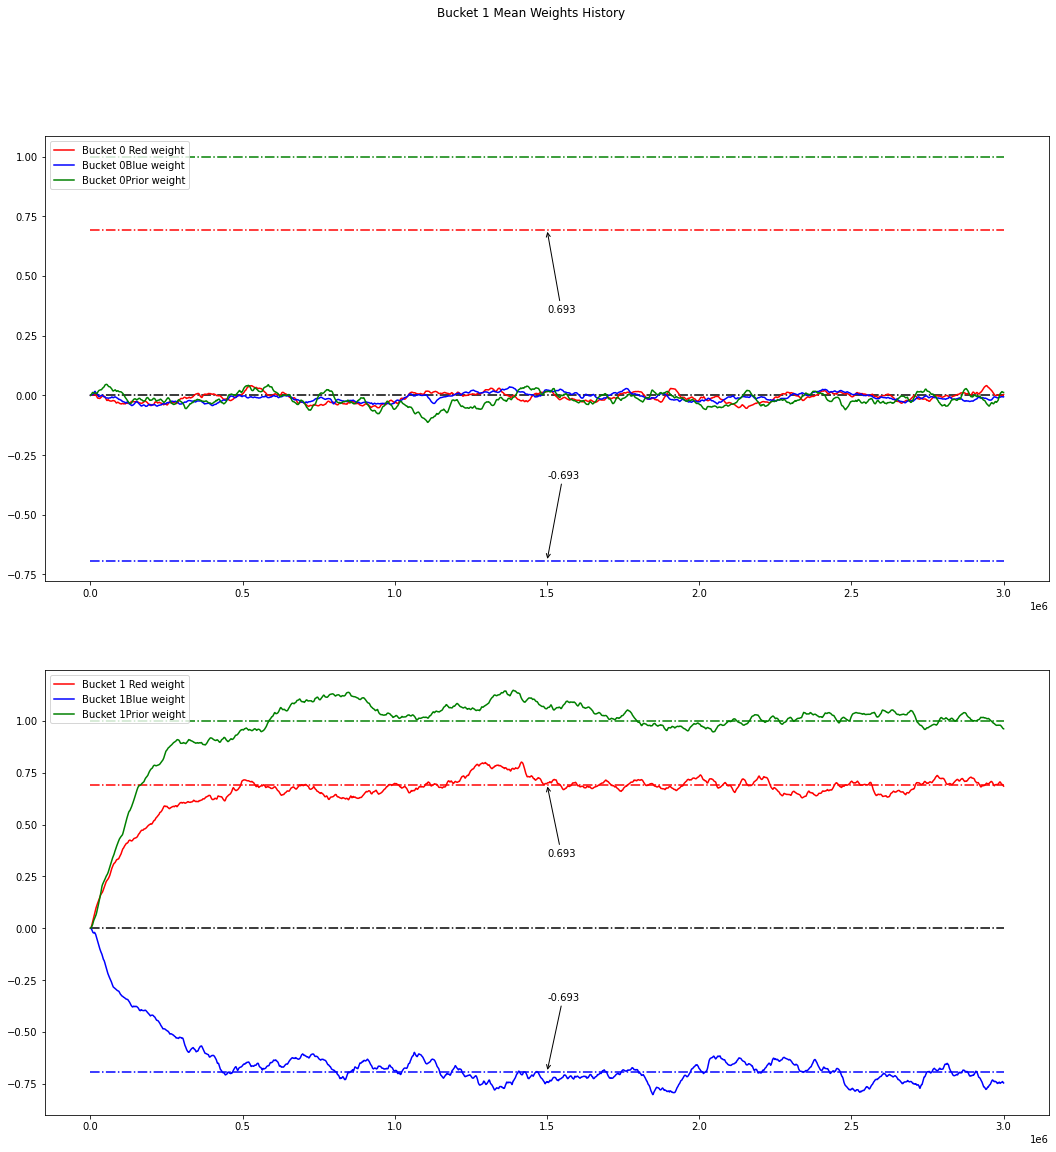

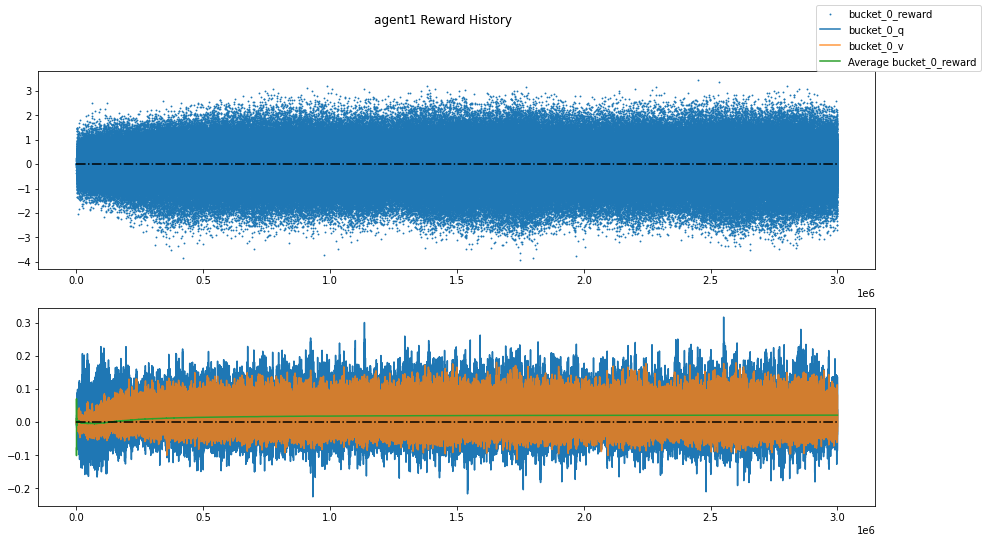

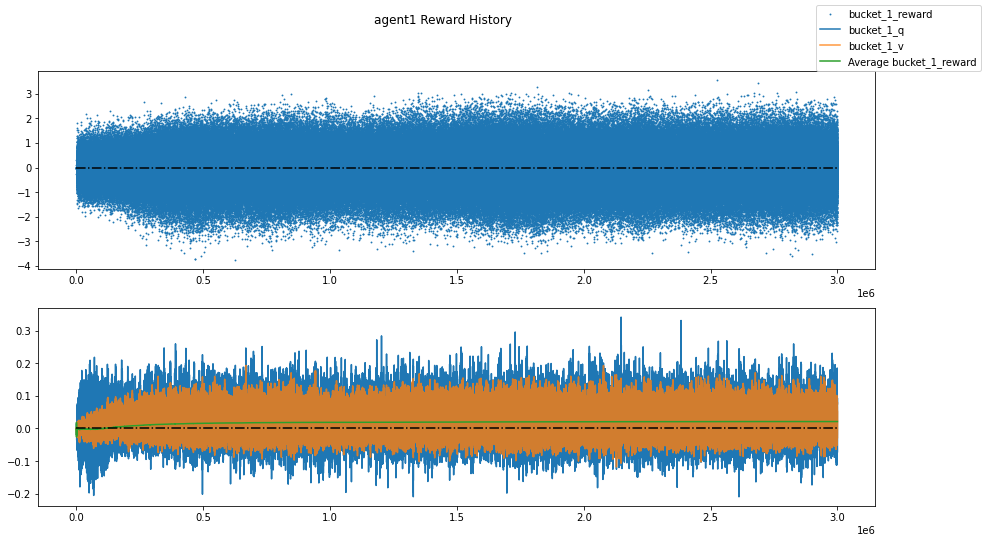

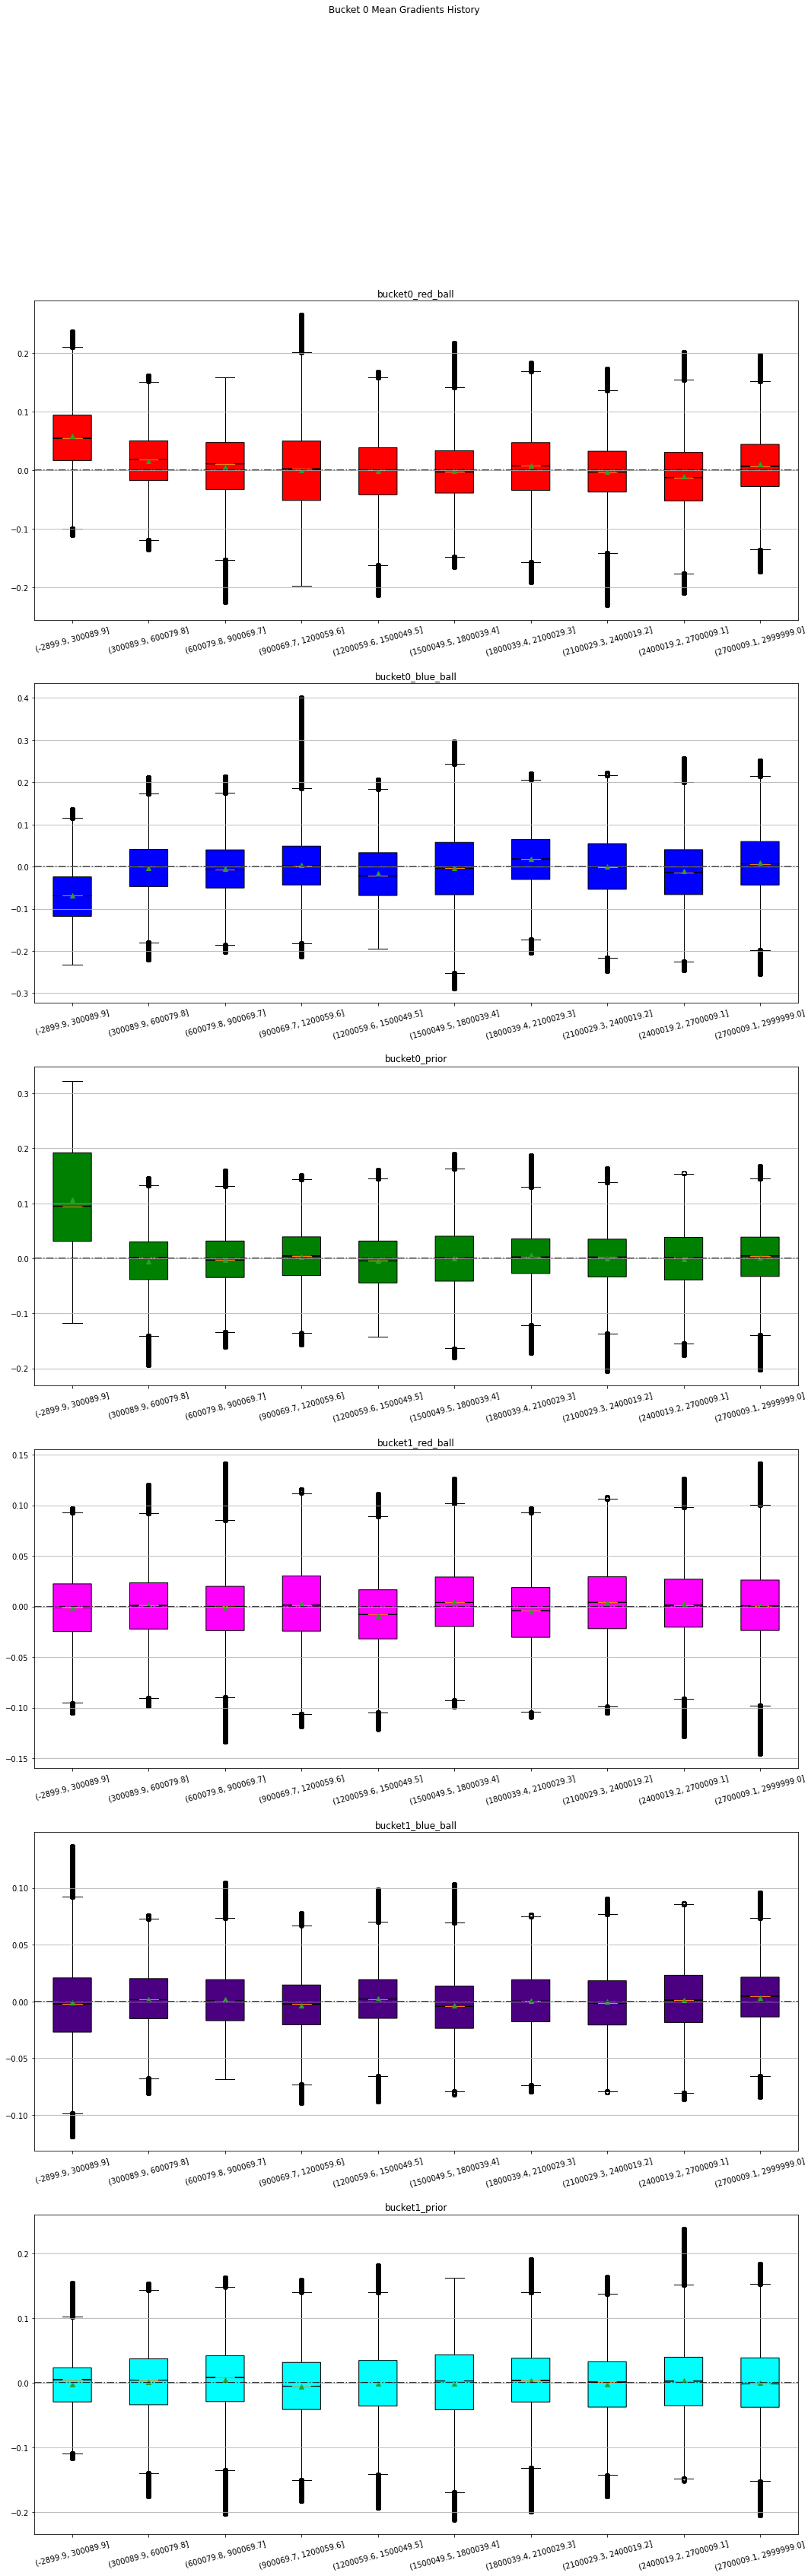

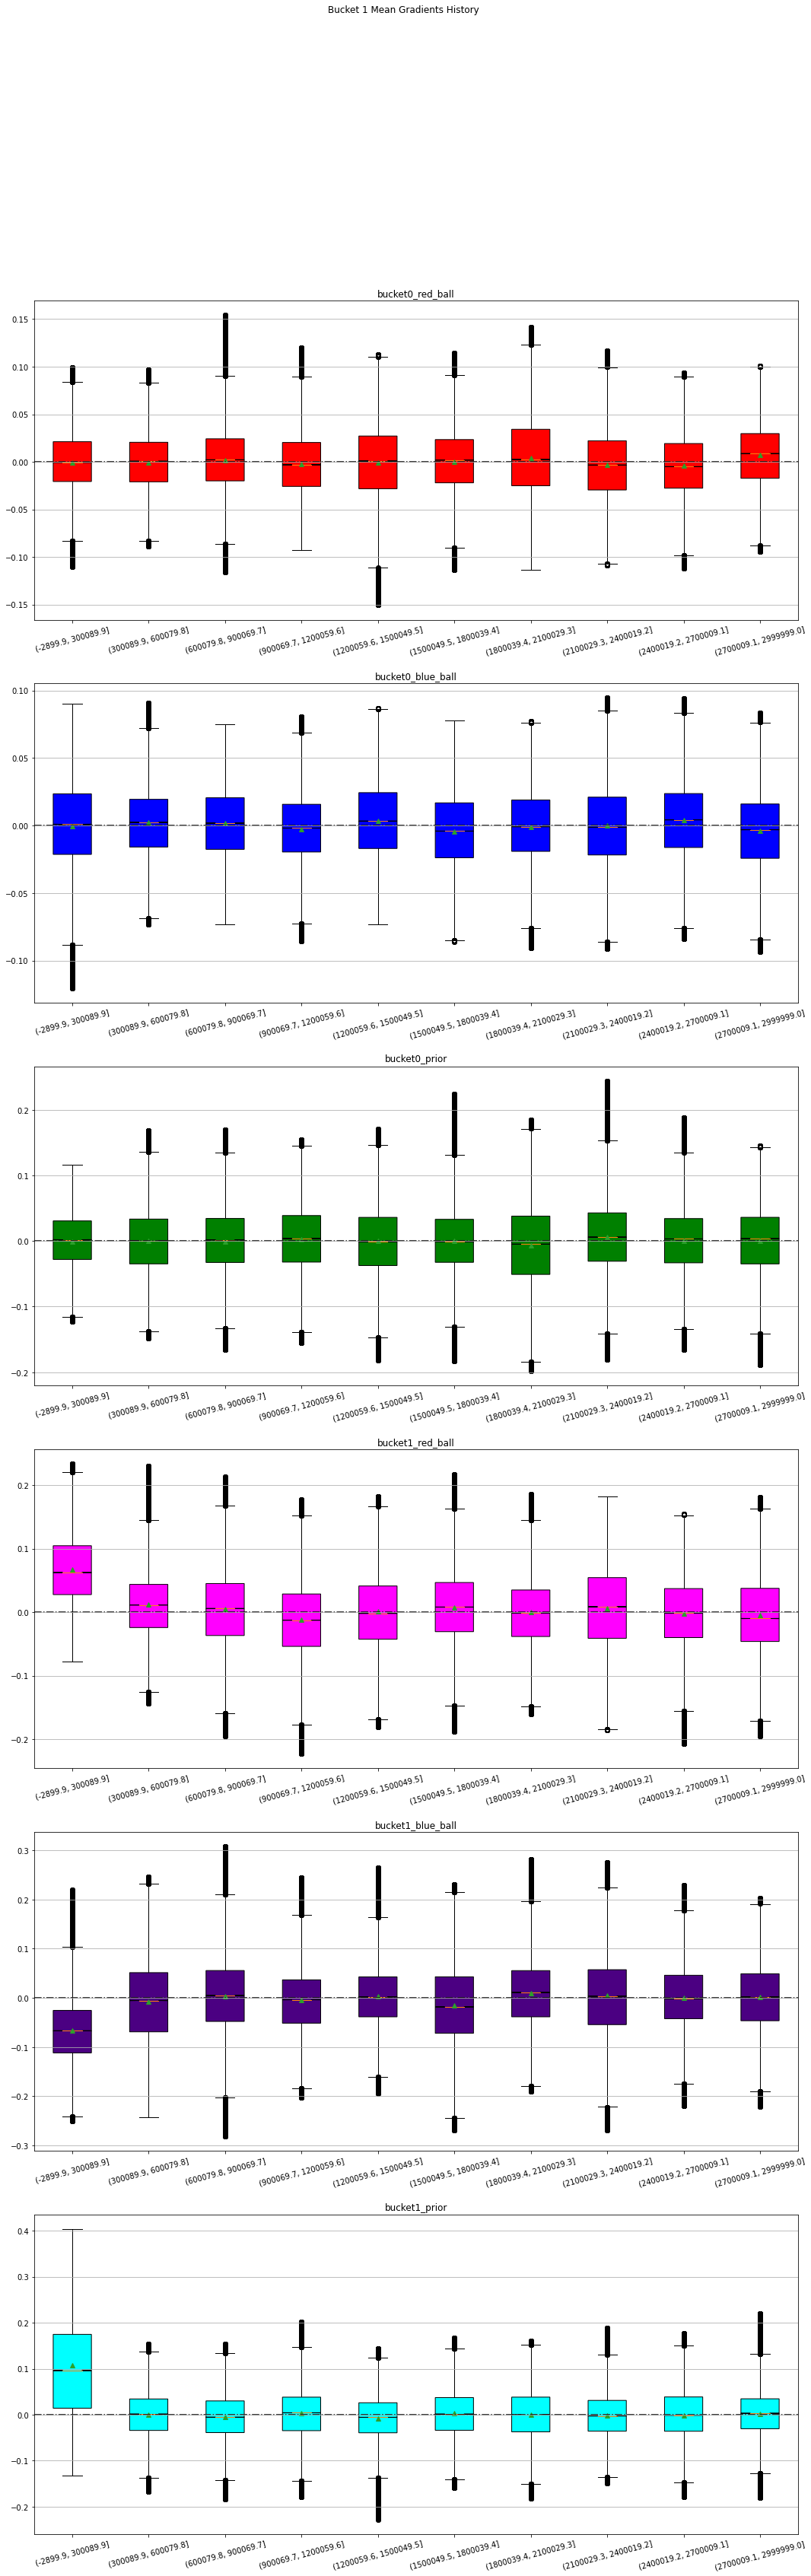

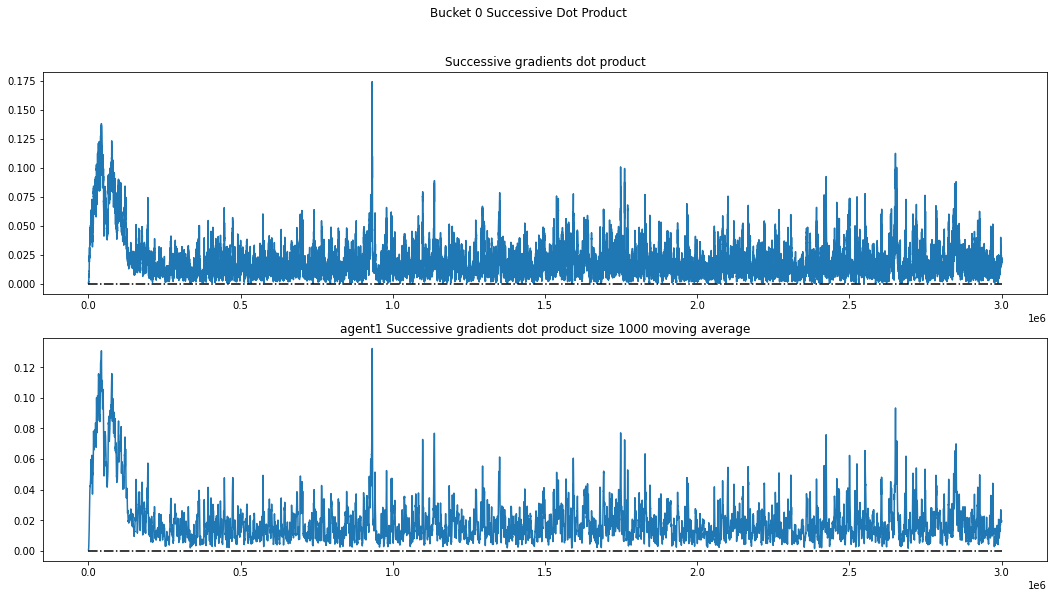

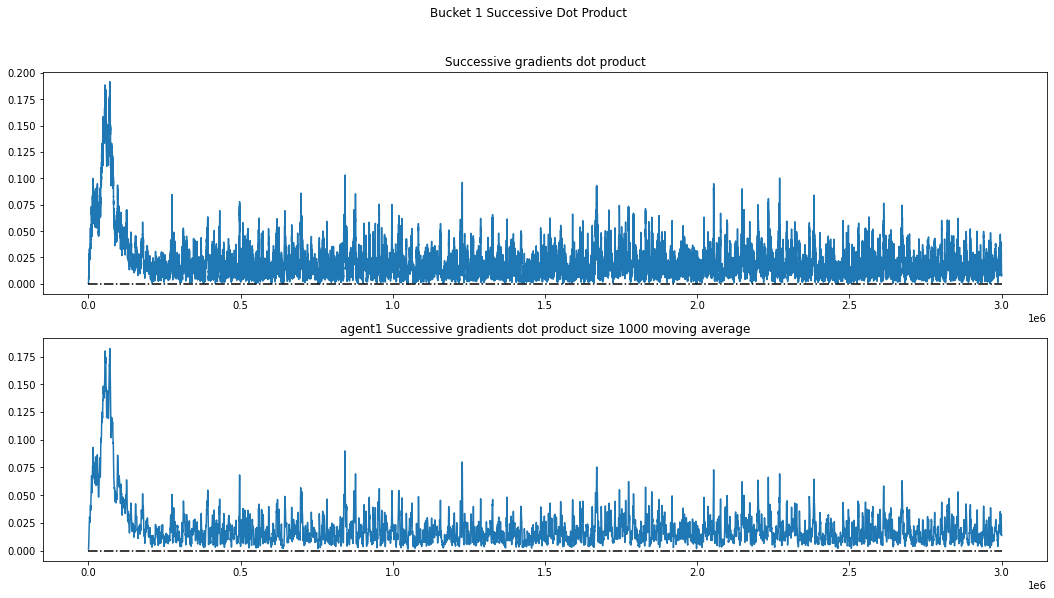

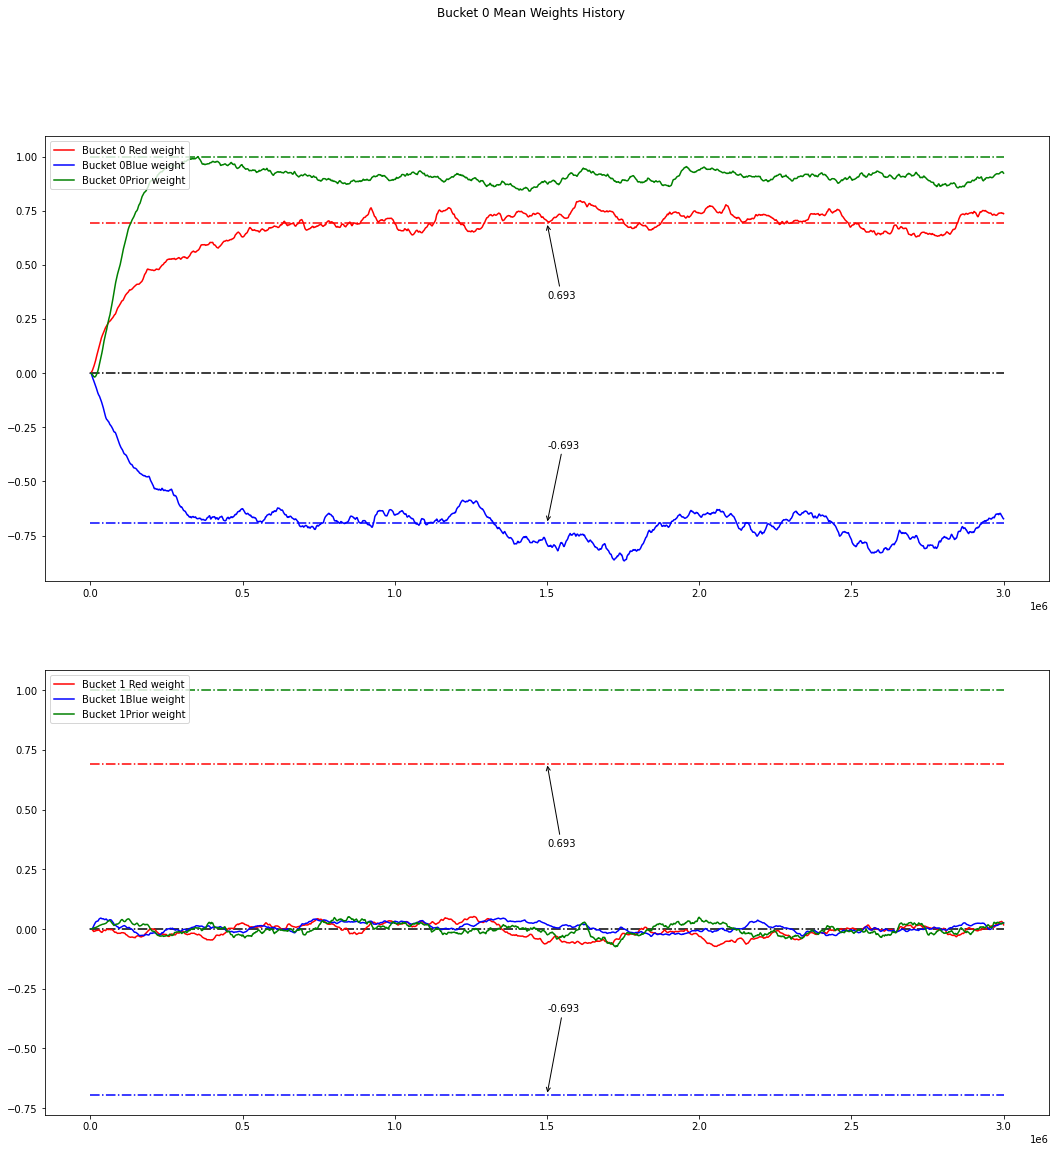

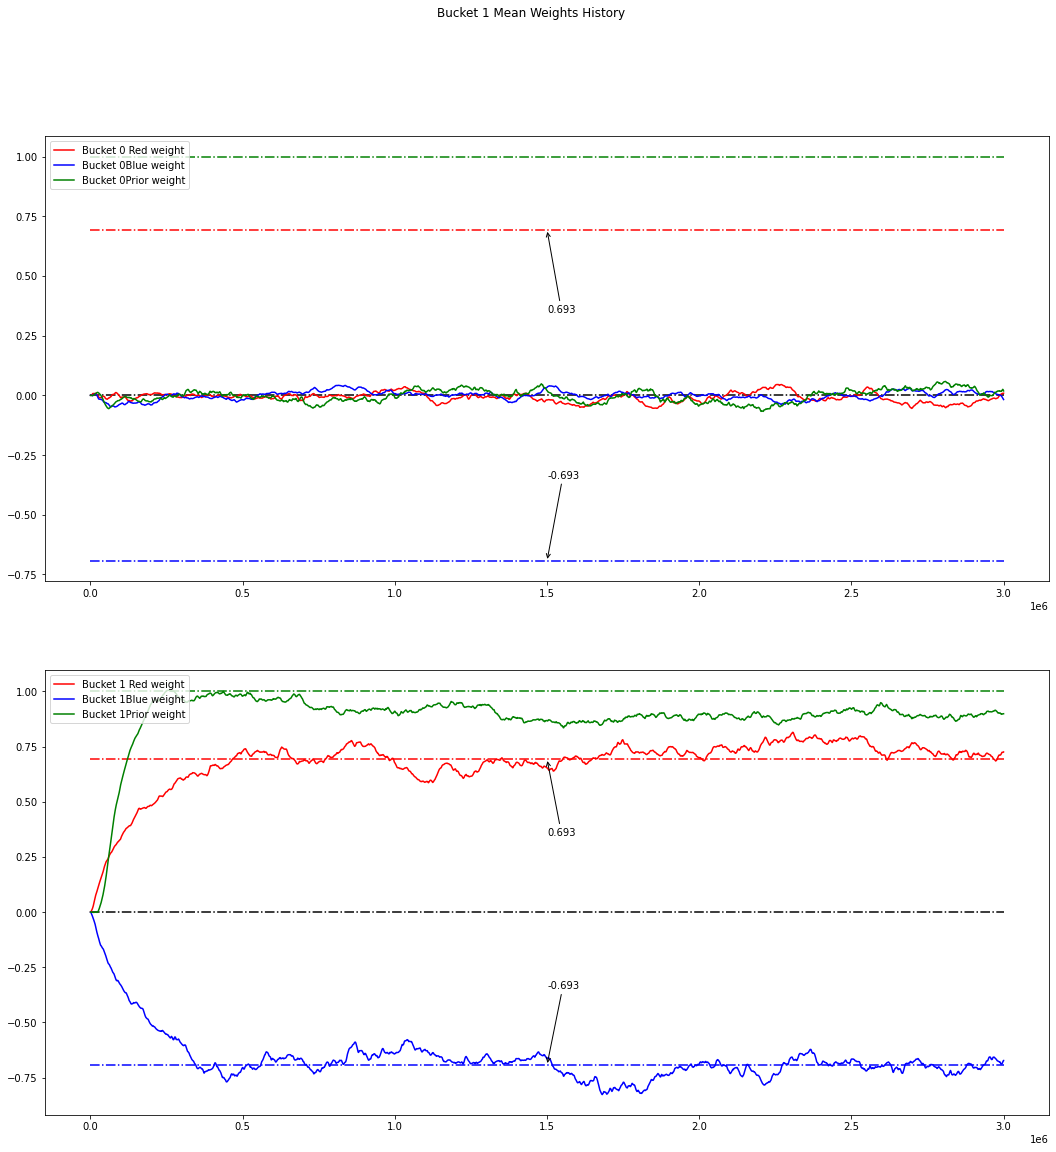

In [5]:
for agent in agent_list:
    agent.reward_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
    agent.mean_weights_history_plot()

In [6]:
# agent_list[0].gradients_history_plot('q')
# agent_list[0].gradients_successive_dot_product_plot('q')
# #     agent.mean_history_plot()
# agent_list[0].weights_history_plot('q')

In [7]:
agent_list[0].w_q

array([[ 0.01613107,  0.06266245],
       [ 0.0065514 , -0.02498846],
       [ 0.05713842,  0.0127856 ],
       [-0.01092689, -0.06594342],
       [-0.04668794, -0.03421238],
       [-0.09612956, -0.00364618]])

In [8]:
agent_list[0].w_v

array([[ 0.03737971, -0.00155561],
       [ 0.00611195, -0.00452361],
       [-0.01692968,  0.00832946],
       [-0.01241121,  0.03555763],
       [-0.00171688,  0.06363951],
       [-0.01242466, -0.00942074]])

In [9]:
from Environment import BucketColour, Ball
import numpy as np

In [10]:
signal = agent_list[0].signal_encode(0, Ball.RED, 3/4)

In [11]:
a = np.array([[0.1, 0.1]])
phi_array =  np.matmul(signal.T, a)

In [12]:
phi_array

array([[0.1       , 0.1       ],
       [0.        , 0.        ],
       [0.10986123, 0.10986123],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.10986123, 0.10986123]])

In [31]:
v_array = np.matmul(signal, agent_list[0].w_v)

In [32]:
v_array

array([[0.03632203, 0.01079974]])

In [33]:
q_array = np.sum(phi_array * agent_list[0].w_q, axis=0, keepdims=True)
q_array

array([[-0.00066399,  0.00138547]])